In [3]:
# Imports
import numpy as np
import csv
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint as sp_randint
import sklearn
import lightgbm as lgb  # brew install lightgbm (on MacOS)
import pickle
from IPython.display import Image
from subprocess import call

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import export_graphviz

/Users/hanae/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Load data

In [4]:
train = pd.read_csv(os.path.join("cs5228", "train.csv"))
X_train = train.drop(["exceeds50K"], axis=1)
y_train = train["exceeds50K"]
X_test = pd.read_csv(os.path.join("cs5228", "test.csv"))
print(list(X_train.columns))
print(X_train.shape, X_test.shape)

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
(24421, 13) (24421, 13)


# Preprocessing

- group countries per regions: "United-States”, "North-America” (Canada), “Mexico", "Central-South-America”, "Western-Europe”, "Eastern-Europe”, "South-East-Asia”, "Asia”, “India”, “Iran”, "South"
- take the log of fnlwgt
- take the log of capital gain
- take the log of capital loss
- drop education
- one-hot-encoding

In [5]:
### Countries per region
new_countries = {
    "United-States": [' United-States'],
    "South-East-Asia": [' Philippines', ' Cambodia' ,' Laos', ' Vietnam', ' Thailand'],
    "North-America": [' Canada'],
    "Mexico": [' Mexico'],
    "Central-South-America": [' Columbia', ' Cuba', ' Dominican-Republic', ' Ecuador',
                              ' El-Salvador', ' Guatemala', ' Honduras', ' Jamaica', ' Peru',
                              ' Puerto-Rico', ' Trinadad&Tobago', ' Outlying-US(Guam-USVI-etc)',
                              ' Haiti', ' Nicaragua'],
    "Western-Europe": [' England', ' France', ' Germany', ' Holand-Netherlands',
                       ' Ireland', ' Scotland', ' Italy', ' Portugal'],
    "Eastern-Europe": [' Hungary', ' Greece', ' Yugoslavia', ' Poland'],
    "Asia": [' China', ' Hong', ' Japan', ' Taiwan'],
    "India": [' India'],
    "Iran": [' Iran'],
    "South": [' South'],
}

for k, v in new_countries.items():

    X_train['native-country'] = X_train['native-country'].replace(v, k)

    X_test['native-country'] = X_test['native-country'].replace(v, k)

### Log fnlwgt
X_train['fnlwgt'] = np.log(X_train['fnlwgt'])

X_test['fnlwgt'] = np.log(X_test['fnlwgt'])

### Log capital gain and loss
X_train['capital-gain'] = np.log(X_train['capital-gain']).replace(-np.inf, 0)

X_train['capital-loss'] = np.log(X_train['capital-loss']).replace(-np.inf, 0)

X_test['capital-gain'] = np.log(X_test['capital-gain']).replace(-np.inf, 0)

X_test['capital-loss'] = np.log(X_test['capital-loss']).replace(-np.inf, 0)

### Drop education, keep only education-num
X_train = X_train.drop(['education'], axis=1)

X_test = X_test.drop(['education'], axis=1)

X_train['relationship'] = X_train['relationship'].replace(to_replace =[" Wife", " Husband"], value='Spouse')

X_test['relationship'] = X_test['relationship'].replace(to_replace =[" Wife", " Husband"], value='Spouse')

### One-hot-encoding
X_train = pd.get_dummies(X_train)

X_test = pd.get_dummies(X_test)

/Users/hanae/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
print(X_train.shape)
X_train.head()

(24421, 56)


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,...,native-country_Central-South-America,native-country_Eastern-Europe,native-country_India,native-country_Iran,native-country_Mexico,native-country_North-America,native-country_South,native-country_South-East-Asia,native-country_United-States,native-country_Western-Europe
0,30,11.899649,10,0.000000,0.0,30,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,60,12.066581,13,0.000000,0.0,42,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,52,11.565784,10,0.000000,0.0,12,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,37,11.630682,13,0.000000,0.0,60,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,63,11.833871,10,8.895356,0.0,48,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# Parameter optimisation: gridsearch using 5-fold CV for evaluation

In [7]:
## Create a parameter grid for gridsearch

# Create the random grid
random_grid = {
    'objective': ['binary'],
    'num_leaves': [5, 10, 20, 50], 
    'min_data_in_leaf': [0, 10, 20, 40],
    'max_depth': [5, 10, 15],
    'max_bin': [5, 10, 25, 50],
    'learning_rate':[0.001, 0.01, 0.1],
    'dart': [True, False],
    'reg_alpha': [0, 1e-2, 1e-1, 1, 10, 100],
    'reg_lambda': [0, 1e-2, 1e-1, 1, 10, 100],
    'n_estimators': [1000, 5000, 10000],
    'bootstrap': [True, False]
        }
               
print(random_grid)

{'objective': ['binary'], 'num_leaves': [5, 10, 20, 50], 'min_data_in_leaf': [0, 10, 20, 40], 'max_depth': [5, 10, 15], 'max_bin': [5, 10, 25, 50], 'learning_rate': [0.001, 0.01, 0.1], 'dart': [True, False], 'reg_alpha': [0, 0.01, 0.1, 1, 10, 100], 'reg_lambda': [0, 0.01, 0.1, 1, 10, 100], 'n_estimators': [1000, 5000, 10000], 'bootstrap': [True, False]}


In [8]:
## Use the random grid to search for best hyperparameters

# First create the base model to tune
gb = lgb.LGBMClassifier()
# Random search of parameters, using 3 fold cross validation, search across n_iter different combinations, and use all available cores
gb_gridsearch = RandomizedSearchCV(estimator=gb, param_distributions=random_grid, n_jobs=4,
                                   scoring="f1_weighted", n_iter=2000, cv=5, verbose=6, random_state=42)
# Fit the random searfch model
gb_gridsearch.fit(X_train, y_train)
# Print best parameters according to gridsearch
gb_gridsearch.best_params_

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed: 10.5min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 19.0min
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed: 27.2min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 42.4min
[Parallel(n_jobs=4)]: Done 605 tasks      | elapsed: 61.4min
/Users/hanae/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 78.3min
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed: 101.7min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 124.8min
[Parallel(n_jobs=4)

{'reg_lambda': 100,
 'reg_alpha': 0,
 'objective': 'binary',
 'num_leaves': 20,
 'n_estimators': 5000,
 'min_data_in_leaf': 10,
 'max_depth': 15,
 'max_bin': 50,
 'learning_rate': 0.01,
 'dart': True,
 'bootstrap': True}

In [9]:
## Evaluate improvment between the base model and the fine-tuned model

base_model = RandomForestClassifier(n_estimators=100, random_state=42)
cv_score_base = cross_val_score(base_model, X_train, y_train, cv=5, verbose=6, scoring='f1_macro')
print(cv_score_base.mean(), cv_score_base.std())

best_params = {
'reg_lambda': 100,
 'reg_alpha': 0,
 'objective': 'binary',
 'num_leaves': 20,
 'n_estimators': 5000,
 'min_data_in_leaf': 10,
 'max_depth': 15,
 'max_bin': 50,
 'learning_rate': 0.01,
 'dart': True,
 'bootstrap': True}

# best_model = gb_gridsearch.best_estimator_
best_model = lgb.LGBMClassifier(**best_params, random_state=42)
cv_score_best = cross_val_score(best_model, X_train, y_train, cv=5, verbose=6, scoring='f1_macro')
print(cv_score_best.mean(), cv_score_best.std())

print('Improvement of {:0.2f}%.'.format(100 * (cv_score_best.mean() - cv_score_base.mean()) / cv_score_base.mean()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.786, total=   3.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


[CV] .................................... , score=0.818, total=   4.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.3s remaining:    0.0s


[CV] .................................... , score=0.784, total=   3.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.6s remaining:    0.0s


[CV] .................................... , score=0.780, total=   4.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   15.8s remaining:    0.0s


[CV] .................................... , score=0.786, total=   4.1s
0.7909456607460801 0.01387381104565754
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   19.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   19.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... , score=0.814, total=  53.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   53.7s remaining:    0.0s


[CV] .................................... , score=0.832, total=  39.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


[CV] .................................... , score=0.819, total=  53.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.4min remaining:    0.0s


[CV] .................................... , score=0.820, total=  48.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.3min remaining:    0.0s


[CV] .................................... , score=0.806, total=  52.7s
0.8181828777605611 0.008290699582569092
Improvement of 3.44%.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.1min finished


# Train on whole dataset using optimised set of parameters

In [10]:
# final_model = lgb.LGBMClassifier(**gb_gridsearch.best_params_, random_state=42
final_model = lgb.LGBMClassifier(**best_params, random_state=42)
final_model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', bootstrap=True, class_weight=None,
               colsample_bytree=1.0, dart=True, importance_type='split',
               learning_rate=0.01, max_bin=50, max_depth=15,
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=10, min_split_gain=0.0, n_estimators=5000,
               n_jobs=-1, num_leaves=20, objective='binary', random_state=42,
               reg_alpha=0, reg_lambda=100, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

# Predict on test and save

In [12]:
print(X_test.shape, X_train.shape)

(24421, 56) (24421, 56)


,prediction
id,
1,0
2,0
3,0
4,0
5,0


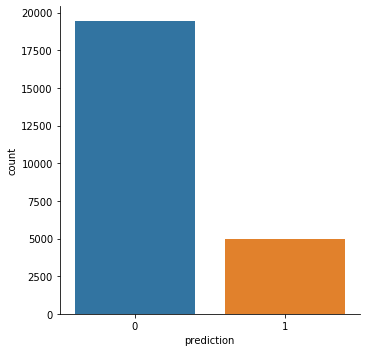

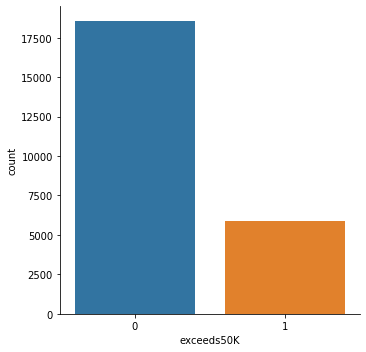

In [13]:
y_test = final_model.predict(X_test)

res = {}
res["prediction"] = y_test
df = pd.DataFrame(res)
df.index += 1
df.index.name = 'id'
sns.catplot(x="prediction", kind="count", data=df)
sns.catplot(x="exceeds50K", kind="count", data=train)
df.head()

In [14]:
# experience name
experience = 'LightGBM_preprocessingHanae'

if not os.path.exists(os.path.join('dump', experience)):
    os.mkdir(os.path.join('dump', experience))

X_train.to_csv(os.path.join('dump', experience, 'X_train.csv'))
X_test.to_csv(os.path.join('dump', experience, 'X_test.csv'))
pickle.dump(final_model, open(os.path.join('dump', experience, 'model'), 'wb'))
df.to_csv(os.path.join('dump', experience, experience+'.csv'))

# Feature importance

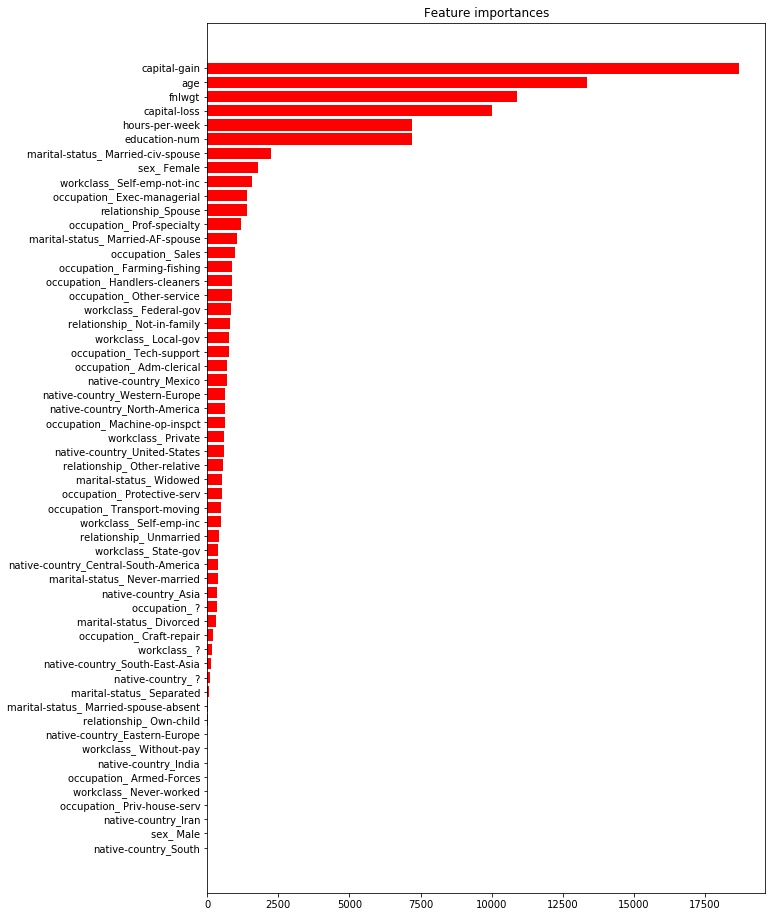

In [15]:
importances = final_model.feature_importances_
indices = np.argsort(importances)[::-1]
colnames = list(X_train)

fig, ax = plt.subplots(1, 1, figsize=(10,16))
ax.set_title("Feature importances")
ax.barh(range(len(colnames)), importances[indices[::-1]],
        color="r", align="center")
ax.set_yticks(range(len(colnames)))
ax.set_yticklabels(np.array(colnames)[indices][::-1])
plt.show()

In [16]:
X_train = pd.read_csv(os.path.join('dump', experience, 'X_train.csv'), index_col=0)
final_model = pickle.load(open(os.path.join('dump', experience, 'model'), 'rb'))
lgb.create_tree_digraph(final_model).save(directory=os.path.join('dump', experience), filename='tree.dot')
call(['dot', '-Tpng', os.path.join('dump', experience, 'tree.dot'),
      '-o', os.path.join('dump', experience, 'tree.png'), '-Gdpi=600'])
# Display in jupyter notebook
Image(filename = os.path.join('dump', experience, 'tree.png'))